Leggo file e definisco variabili

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

all_data = pd.read_csv("G:\My Drive\Datasets\data_per20.csv")

# 'all_data' contiene 20 array (classi) da 8000 elementi: 160000 elementi
print("Shape of concatenated data:", all_data.shape)

Shape of concatenated data: (160000, 785)


In [2]:
classes = {0:'airplane',
           1: 'apple',
           2: 'banana',
           3: 'cactus',
           4: 'car',
           5: 'clock',
           6: 'cloud',
           7: 'door',
           8: 'eye',
           9: 'fish',
           10: 'fork',
           11: 'ice cream',
           12: 'line',
           13: 'lollipop',
           14: 'octopus',
           15: 'pencil',
           16: 'smiley face',
           17: 'star',
           18: 'sun',
           19: 'umbrella'}

In [3]:
from sklearn.model_selection import train_test_split

y = all_data.iloc[:, 0]  # 1a colonna: labels
x = all_data.iloc[:, 1:] # tutte le colonne tranne la 1a
x = x.to_numpy()
y = y.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 42)

# Normalizzo i dati di input per assicurare che le feature siano su una scala simile per un addestramento + stabile ed efficiente
x_train = x_train.astype('float64')
x_test = x_test.astype('float64')
x_train /= 255
x_test /= 255

print(x_train.shape, x_test.shape)

m = x_train.shape[0] # 112000
n = x_train.shape[1]+1 # 785
x_train, y_train, x_test, y_test = x_train.T, y_train.T, x_test.T, y_test.T # transpongo tutto

# Labels names
y_test_names = [classes[i] for i in y_test]

(112000, 784) (48000, 784)


Neural Network from scratch

In [4]:
def init_params():
    W1 = np.random.rand(20, 784) - 0.5
    b1 = np.random.rand(20, 1) - 0.5
    W2 = np.random.rand(20, 20) - 0.5
    b2 = np.random.rand(20, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y): # tutti i bit sono 0 tranne un 1
    one_hot_Y = np.zeros((Y.size, Y.max() + 1)) #112000, 20
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T #20, 112000
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

In [5]:
def get_predictions(A2):
    return np.argmax(A2, 0) # returns l'indice massimo nella colonna (che è una, quindi nell'array)

def get_accuracy(predictions, Y): # predizioni giuste / predizioni tot
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def get_loss(predictions, Y): # log-likelihood
    one_hot_Y = one_hot(Y)
    loss = -np.sum(one_hot_Y * np.log(predictions + 1e-10)) / m # + epsilon per evitare log(0) o loss infinito
    return loss



def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()

    # liste per il grafico
    train_loss_history = []
    train_accuracy_history = []
    test_loss_history = []
    test_accuracy_history = []

    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)

            # Metrics del training set
            train_predictions = get_predictions(A2)
            train_accuracy = get_accuracy(train_predictions, Y)
            train_loss = get_loss(train_predictions, Y)
            train_loss_history.append(train_loss)
            train_accuracy_history.append(train_accuracy)

            # Metrics del test set (prima mi servono i parametri)
            test_Z1, test_A1, test_Z2, test_A2 = forward_prop(W1, b1, W2, b2, x_test)
            test_predictions = get_predictions(test_A2)
            test_accuracy = get_accuracy(test_predictions, y_test)
            test_loss = get_loss(test_predictions, y_test)
            test_accuracy_history.append(test_accuracy)
            test_loss_history.append(test_loss)

            print("Training Loss:", np.abs(train_loss), " Training Accuracy:", train_accuracy, "\nTest Loss:", np.abs(test_loss), " Test Accuracy:", test_accuracy)

        if i == iterations-1: #fine
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print("Total Accuracy:",get_accuracy(predictions, Y))

    return W1, b1, W2, b2, train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history

Fase di training

In [6]:
W1, b1, W2, b2, train_loss_history, train_accuracy_history, test_loss_history, test_accuracy_history = gradient_descent(x_train, y_train, 0.13, 1000)

Iteration:  0
[ 7 18  6 ...  1  8  7] [ 3  7  7 ... 16 18 15]
[ 7 18 12 ...  5 14  6] [15  4  9 ...  1 12 17]
Training Loss: 1.461018637312657  Training Accuracy: 0.048214285714285716 
Test Loss: 0.5332134920374112  Test Accuracy: 0.0584375
Iteration:  10
[ 5  0  1 ...  1  8 15] [ 3  7  7 ... 16 18 15]
[15 10  3 ...  5 14  1] [15  4  9 ...  1 12 17]
Training Loss: 1.3640552955617253  Training Accuracy: 0.09610714285714286 
Test Loss: 0.6004797981928064  Test Accuracy: 0.10077083333333334
Iteration:  20
[ 5 14  1 ...  1  3 15] [ 3  7  7 ... 16 18 15]
[15 10  3 ...  5 14  6] [15  4  9 ...  1 12 17]
Training Loss: 1.5512111882469226  Training Accuracy: 0.12183035714285714 
Test Loss: 0.6687213889761793  Test Accuracy: 0.12545833333333334
Iteration:  30
[ 5 14  1 ...  1  3 15] [ 3  7  7 ... 16 18 15]
[15  4  3 ...  5 14  6] [15  4  9 ...  1 12 17]
Training Loss: 1.6631049178280173  Training Accuracy: 0.14200892857142858 
Test Loss: 0.7174473516836211  Test Accuracy: 0.1453125
Iteration:  4

Grafici Accuracy e Loss

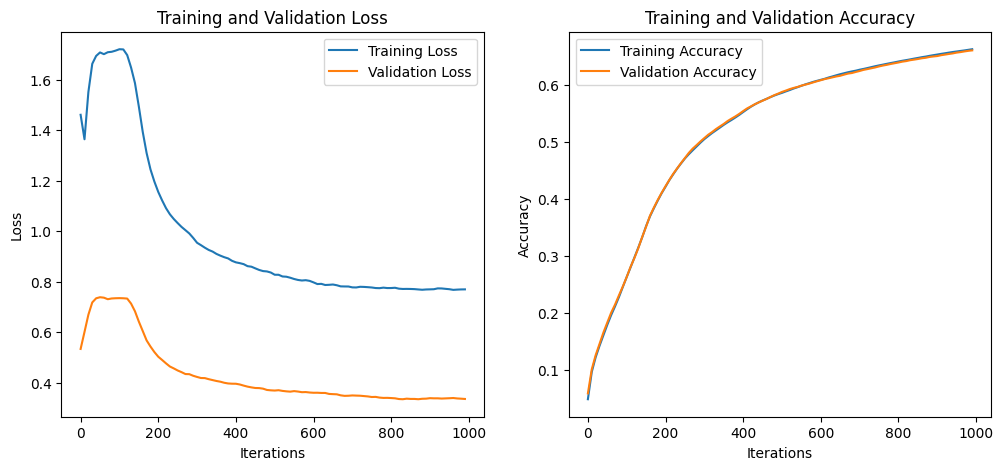

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(0, 1000, 10), np.abs(train_loss_history), label='Training Loss')
plt.plot(range(0, 1000, 10), np.abs(test_loss_history), label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(range(0, 1000, 10), train_accuracy_history, label='Training Accuracy')
plt.plot(range(0, 1000, 10), test_accuracy_history, label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


In [8]:
def predict(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X) # non devo fare backprop perchè ora ho trovato i valori ottimi
    predictions = get_predictions(A2)
    return predictions

y_pred = predict(x_test, W1, b1, W2, b2)
y_pred_names = [classes[i] for i in y_pred]

print("Final test accuracy:", get_accuracy(y_pred, y_test))

[15  4  6 ...  1 12 18] [15  4  9 ...  1 12 17]
Final test accuracy: 0.6613333333333333


Stats (classification_report, confusion_matrix)

Accuracy: 0.6613333333333333
Classification report:
               precision    recall  f1-score   support

    airplane       0.46      0.48      0.47      2350
       apple       0.80      0.83      0.82      2350
      banana       0.64      0.65      0.65      2383
      cactus       0.47      0.43      0.45      2395
         car       0.65      0.70      0.67      2390
       clock       0.76      0.78      0.77      2405
       cloud       0.64      0.60      0.62      2347
        door       0.85      0.85      0.85      2395
         eye       0.53      0.55      0.54      2434
        fish       0.70      0.72      0.71      2491
        fork       0.68      0.62      0.65      2325
   ice cream       0.66      0.73      0.69      2363
        line       0.84      0.82      0.83      2449
    lollipop       0.77      0.77      0.77      2455
     octopus       0.60      0.64      0.62      2446
      pencil       0.62      0.67      0.65      2393
 smiley face       0.64     

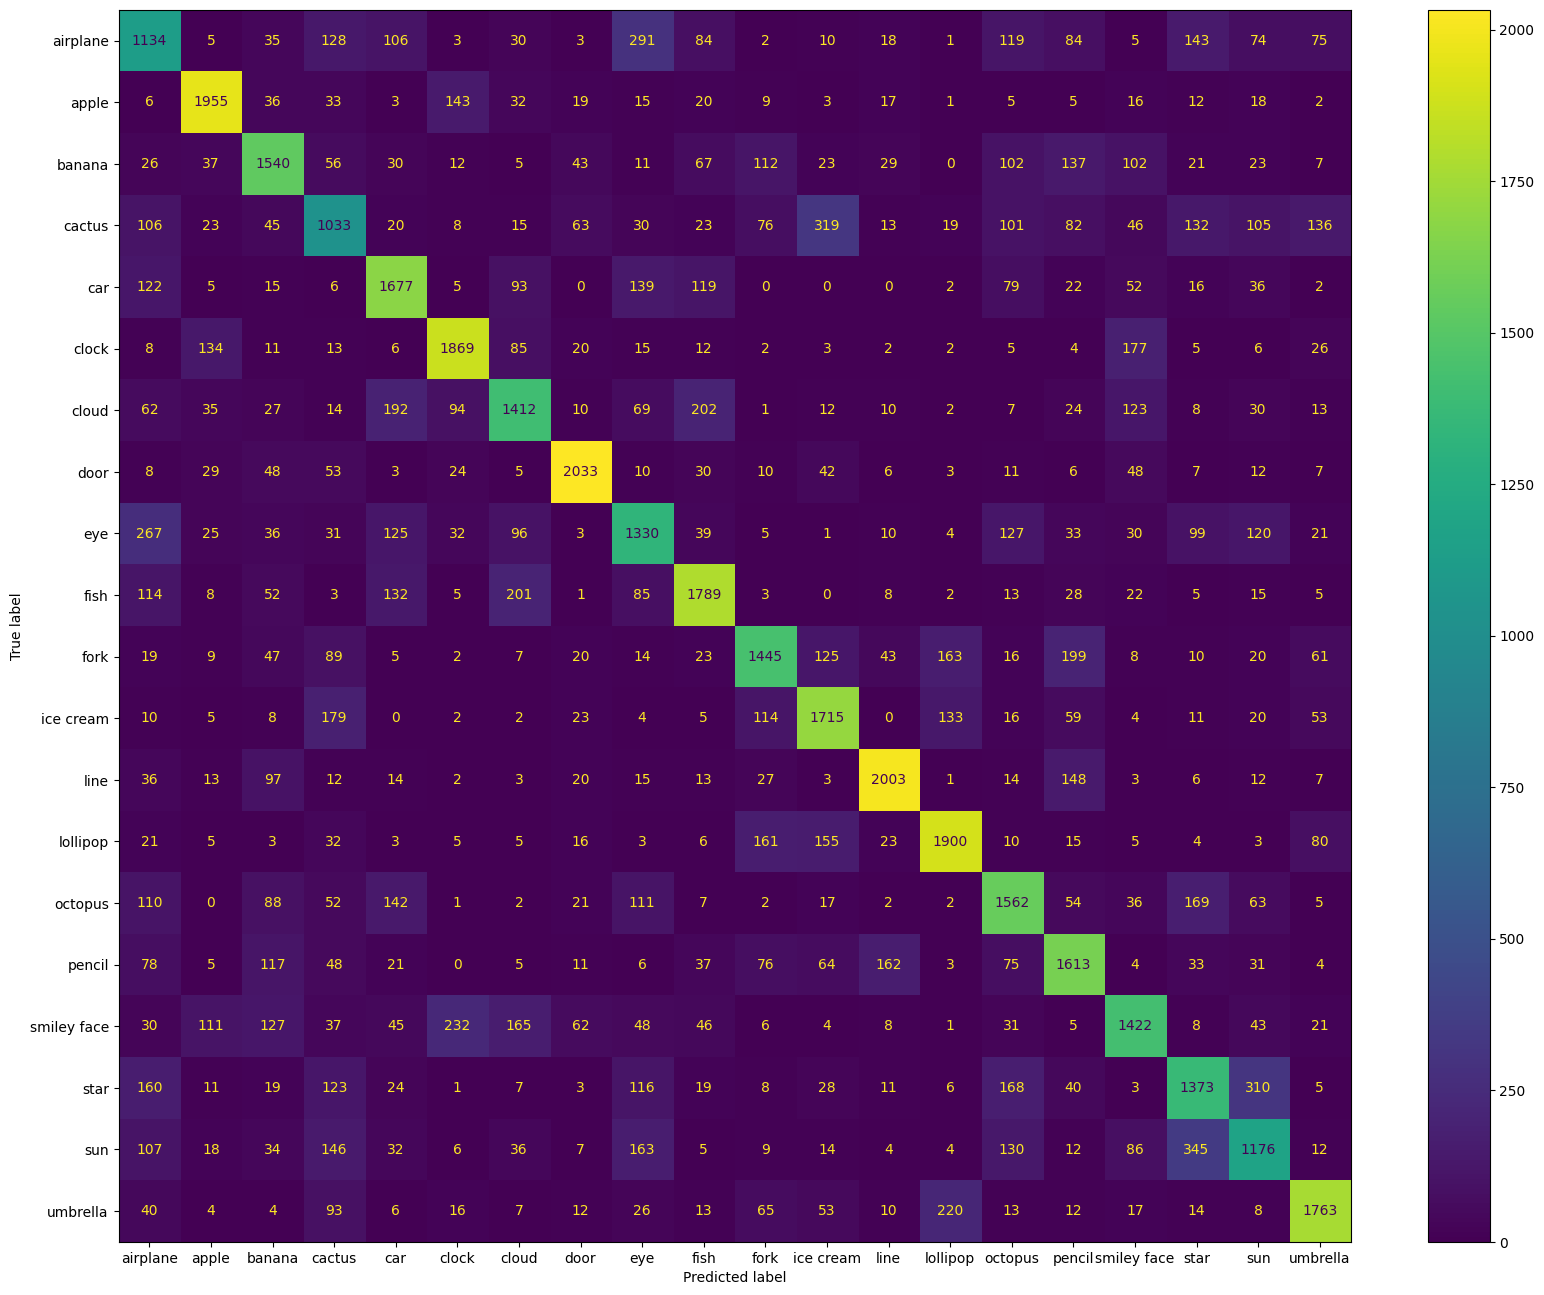

In [9]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay

# stats
def stats(y_test,y_pred):
  print("Accuracy:",accuracy_score(y_test, y_pred))
  print("Classification report:\n", classification_report(y_test_names, y_pred_names))
  # Plotto la confusion matrix
  cm = confusion_matrix(y_test_names, y_pred_names)
  print("Confusion Matrix:\n",cm)
  plt.figure(figsize=(20, 16))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes.values())
  disp.plot(ax=plt.gca())  # passo l'asse corrente (ax) al display
plt.show()

stats(y_test,y_pred)

1a immagine del test set

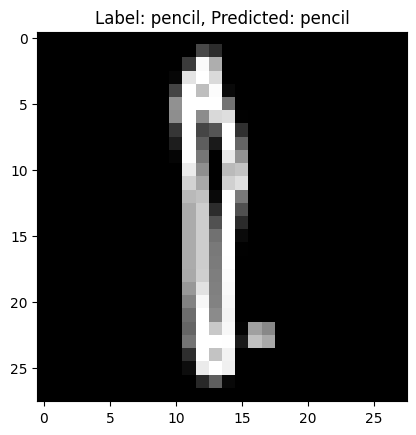

In [10]:
def image(i):
  image = x_test[:,i,None]
  plt.imshow(image.reshape((28, 28)), cmap='gray')
  plt.title(f"Label: {y_test_names[i]}, Predicted: {y_pred_names[i]}")
  plt.show()

image(0) # printo la 1a immagine del test set

Prime 16 immagini del test set

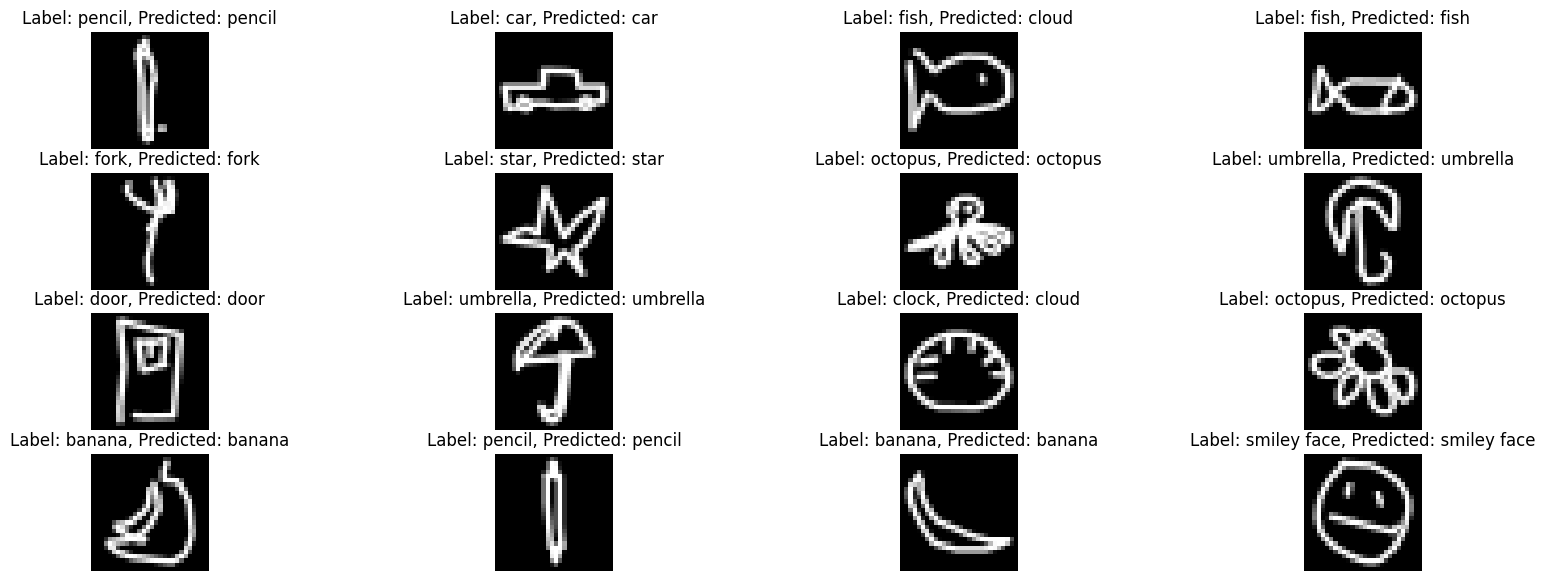

In [11]:
def firstImages(i):
    rows = int(np.sqrt(i))
    cols = i // rows
    images_to_show = x_test[:, :i].reshape(28, 28, i)
    titles = [f"Label: {y_test_names[j]}, Predicted: {y_pred_names[j]}" for j in range(i)]

    fig, axes = plt.subplots(rows, cols, figsize=(20, 7))
    for j, ax in enumerate(axes.flat):
        ax.imshow(images_to_show[:, :, j], cmap='gray')
        ax.set_title(titles[j])
        ax.axis('off')
    plt.show()

firstImages(16) # printo le prime 16 immagini del test set

Primi 16 errori del modello nella fase di test

16256 errori su 48000 immagini totali


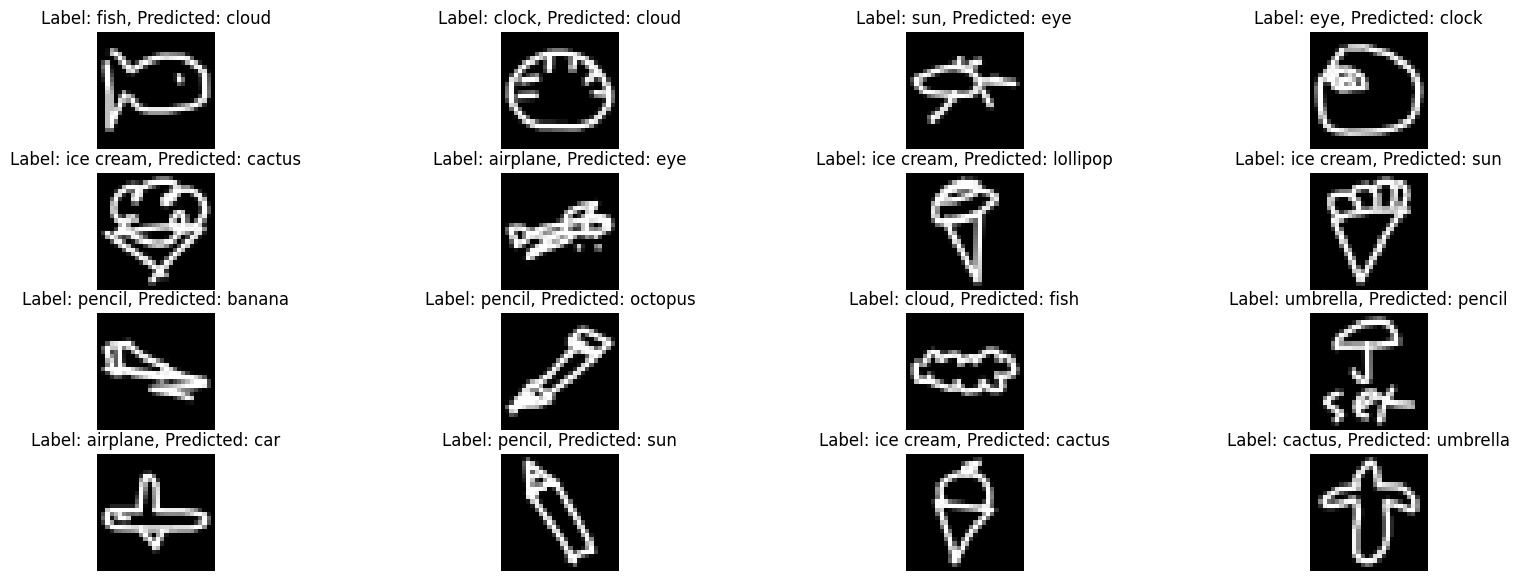

In [12]:
def firstMistakes(i):
    # Trovo tutti gli indici delle immagini misclassified
    misclassified_indices = np.where(y_test != y_pred)[0]
    print(misclassified_indices.shape[0], "errori su", y_test.shape[0], "immagini totali")

    # Display the randomly selected misclassified images
    rows = int(np.sqrt(i))
    cols = i // rows

    image = x_test[:, misclassified_indices[:i]].reshape(28, 28, i)
    titles = [f"Label: {y_test_names[j]}, Predicted: {y_pred_names[j]}" for j in misclassified_indices[:i]]

    fig, axes = plt.subplots(rows, cols, figsize=(20, 7))
    for j, ax in enumerate(axes.flat):
        ax.imshow(image[:,:,j], cmap='gray')
        ax.set_title(titles[j])
        ax.axis('off')
    plt.show()

firstMistakes(16) # printo 16 immagini che sono state classificate male dal modello